In [ ]:
# Import required libraries
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, Sequential
import tensorflow as tf
import itertools

In [ ]:
# Dataset import (Make sure Kaggle API key is uploaded to Colab)
import kagglehub
paultimothymooney_chest_xray_pneumonia_path = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')

print('Data source import complete.')

100%|██████████| 2.29G/2.29G [01:46<00:00, 23.2MB/s]

Extracting files...


Data source import complete.


In [ ]:
# Set the paths for train, validation, and test data
train_data_path = os.path.join(paultimothymooney_chest_xray_pneumonia_path, 'chest_xray', 'train')
valid_data_dir = os.path.join(paultimothymooney_chest_xray_pneumonia_path, 'chest_xray', 'val')
test_data_dir = os.path.join(paultimothymooney_chest_xray_pneumonia_path, 'chest_xray', 'test')


In [ ]:
# Prepare DataFrame for train, validation, and test
def prepare_data(data_dir):
    filepaths = []
    labels = []
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return pd.DataFrame({'filepaths': filepaths, 'label': labels})

train_df = prepare_data(train_data_path)
valid_df = prepare_data(valid_data_dir)
test_df = prepare_data(test_data_dir)

In [ ]:
# Split the data into train, validation, and test sets (80/10/10 split)
train_df, dummy_df = train_test_split(train_df, train_size=0.8, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=42)


In [ ]:
# Image generator setup for data augmentation
batch_size = 16
img_size = (224, 224)

In [ ]:
# Normalize the image pixels by rescaling them to [0, 1]
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
val_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(
    train_df, x_col='filepaths', y_col='label', target_size=img_size, class_mode='categorical',
    batch_size=batch_size, shuffle=True
)
valid_gen = val_gen.flow_from_dataframe(
    valid_df, x_col='filepaths', y_col='label', target_size=img_size, class_mode='categorical',
    batch_size=batch_size, shuffle=True
)
test_gen = ts_gen.flow_from_dataframe(
    test_df, x_col='filepaths', y_col='label', target_size=img_size, class_mode='categorical',
    batch_size=batch_size, shuffle=False
)


Found 4172 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import load_model

# model = load_model('/content/vgg15_1 (1).h5')
model = load_model('/content/vgg15_1.h5')

In [ ]:
# from google.colab import files
# uploaded = files.upload()  # Use this to upload your .h5 file

MessageError: TypeError: Cannot read properties of undefined (reading 'next')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# VGG16 Model with reduced learning rate and fine-tuning
def create_vgg16_model(input_shape=(224, 224, 3)):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze base layers to avoid training them
    for layer in base_model.layers:
        layer.trainable = False

    # Adding top layers for our classification task
    model = Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax')  # 2 classes: NORMAL and PNEUMONIA
    ])
    return model

In [ ]:
# Create and compile the VGG16 model
# model = create_vgg16_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Check if GPU is available and use it
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print("GPU not found. Using CPU for training.")
else:
    print(f"Using GPU: {device_name}")

Using GPU: /device:GPU:0


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
import tensorflow as tf

if tf.test.is_gpu_available():
    print("GPU is available:", tf.test.gpu_device_name())
else:
    print("No GPU detected")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


No GPU detected


In [ ]:
from google.colab import files
uploaded = files.upload()  # Use this to upload your .h5 file

Saving vgg15_1.h5 to vgg15_1.h5


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
# Train the model with 15 epochs and multiprocessing
epochs = 50
history = model.fit(
    train_gen, epochs=epochs, validation_data=valid_gen, shuffle=True, verbose=1
)


Epoch 1/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 54s 191ms/step - accuracy: 0.9459 - loss: 3.9892 - val_accuracy: 0.9866 - val_loss: 0.4108
Epoch 2/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 78s 183ms/step - accuracy: 0.9773 - loss: 0.6822 - val_accuracy: 0.9828 - val_loss: 0.1591
Epoch 3/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 97s 242ms/step - accuracy: 0.9816 - loss: 0.2469 - val_accuracy: 0.9866 - val_loss: 0.1023
Epoch 4/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 51s 192ms/step - accuracy: 0.9882 - loss: 0.0879 - val_accuracy: 0.9866 - val_loss: 0.1018
Epoch 5/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 85s 203ms/step - accuracy: 0.9923 - loss: 0.0310 - val_accuracy: 0.9866 - val_loss: 0.0762
Epoch 6/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 48s 181ms/step - accuracy: 0.9910 - loss: 0.0259 - val_accuracy: 0.9808 - val_loss: 0.1049
Epoch 7/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 82s 183ms/step - accuracy: 0.9887 - loss: 0.0736 - val_accuracy: 0.9904 - val_loss: 0.0406
Epoch 8/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 52s 196ms/step - accuracy: 0.9923 - loss: 0

In [ ]:
import json

# Assuming `history` is the History object returned by model.fit()
with open('vgg_2_history.json', 'w') as f:
    json.dump(history.history, f)

In [ ]:
# Evaluate the model
train_score = model.evaluate(train_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)

print("Train Loss:", train_score[0])
print("Train Accuracy:", train_score[1])
print("Validation Loss:", valid_score[0])
print("Validation Accuracy:", valid_score[1])
print("Test Loss:", test_score[0])
print("Test Accuracy:", test_score[1])


261/261 ━━━━━━━━━━━━━━━━━━━━ 42s 162ms/step - accuracy: 1.0000 - loss: 2.2195e-05
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - accuracy: 0.9761 - loss: 0.2274
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9729 - loss: 0.3622
Train Loss: 2.4655841116327792e-05
Train Accuracy: 1.0
Validation Loss: 0.29388535022735596
Validation Accuracy: 0.9731800556182861
Test Loss: 0.3940925896167755
Test Accuracy: 0.969348669052124


In [ ]:
# Plot training & validation accuracy and loss
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(14, 6))

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

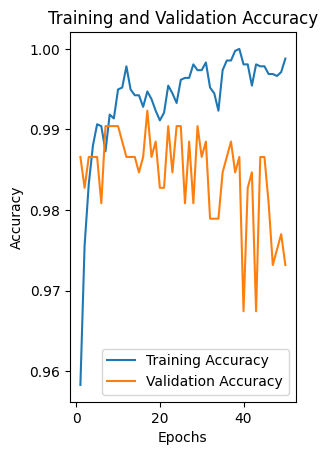

In [ ]:
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

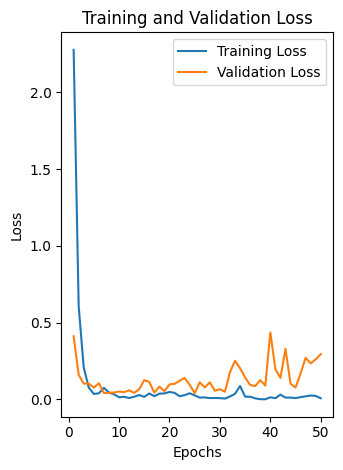

In [ ]:
# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step
Confusion Matrix:
[[127   6]
 [ 10 379]]


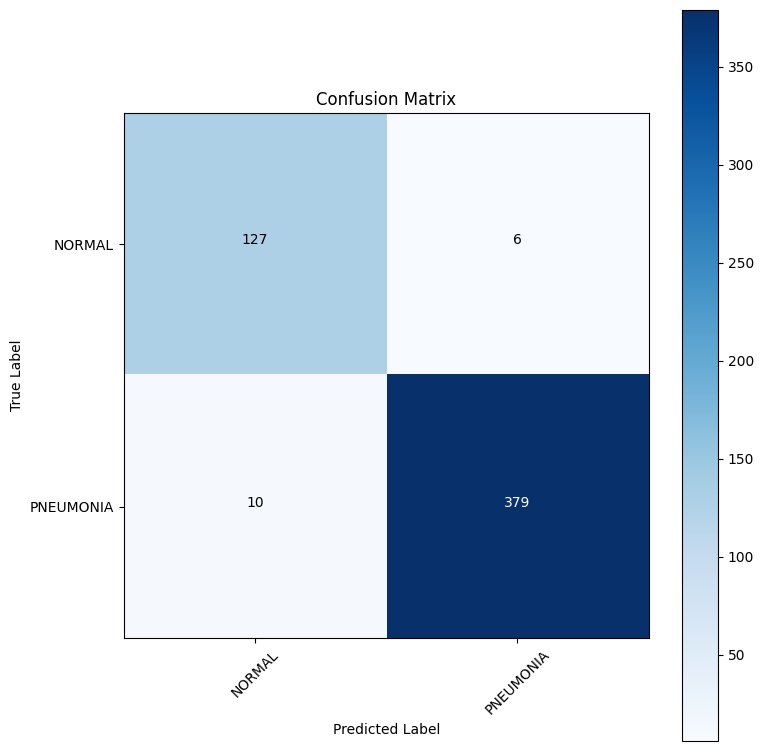

In [ ]:
# Confusion Matrix and Classification Report
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(cm)

plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [ ]:
# Classification report
print('Classification Report:')
print(classification_report(y_true, y_pred, target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.93      0.95      0.94       133
   PNEUMONIA       0.98      0.97      0.98       389

    accuracy                           0.97       522
   macro avg       0.96      0.96      0.96       522
weighted avg       0.97      0.97      0.97       522



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


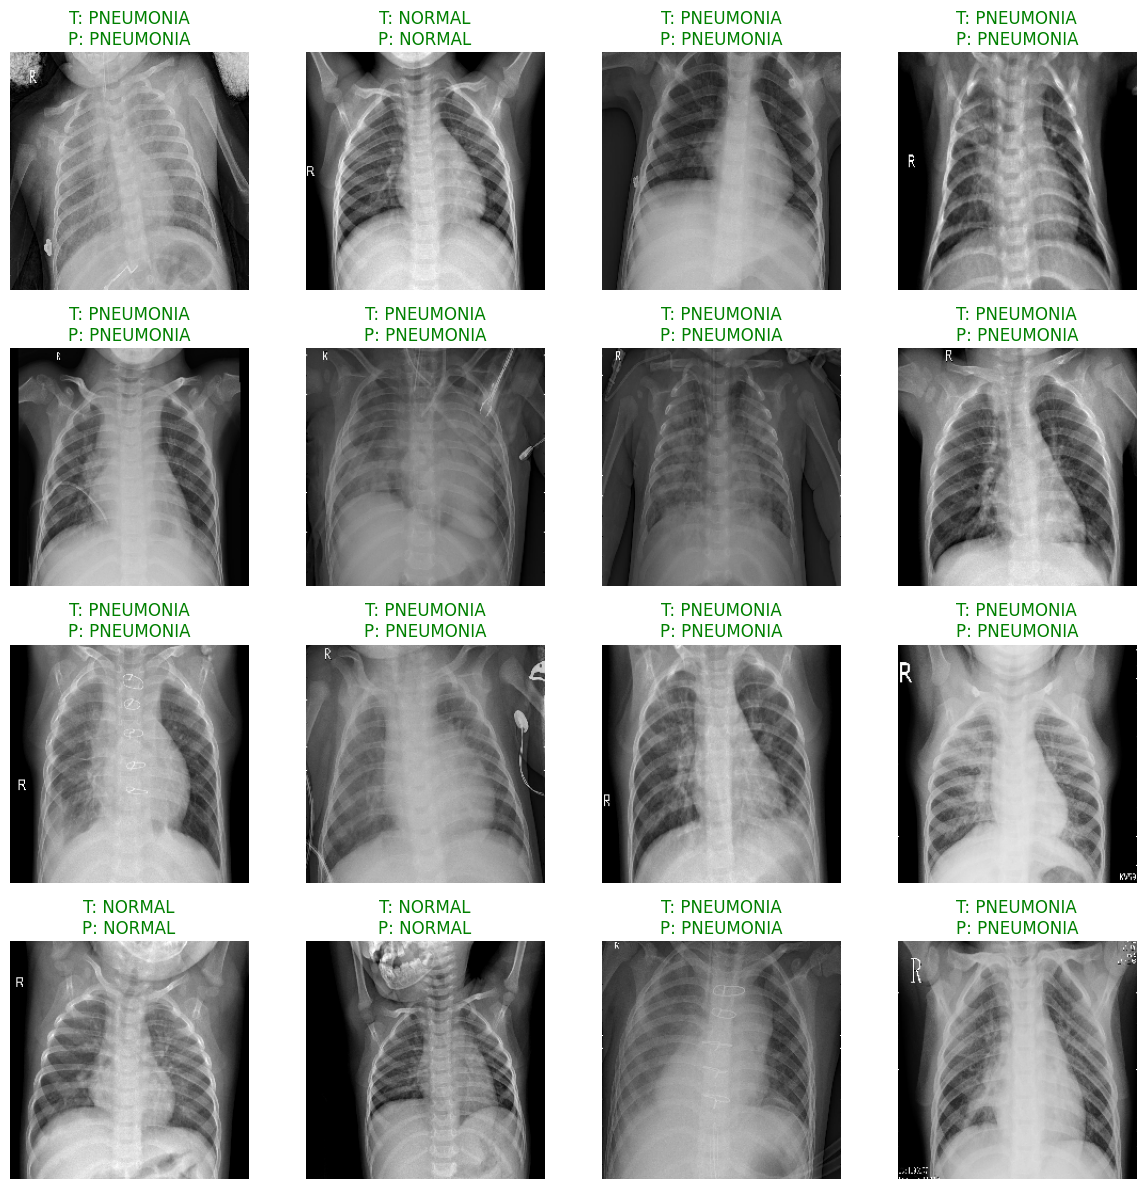

In [ ]:
# Visualize some predictions
x_test, y_true = next(test_gen)
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

plt.figure(figsize=(12, 12))
for i in range(min(16, x_test.shape[0])):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_test[i].astype('uint8'))
    plt.axis('off')
    true_label = class_labels[y_true_classes[i]]
    pred_label = class_labels[y_pred_classes[i]]
    plt.title(f"T: {true_label}\nP: {pred_label}", color=("green" if true_label == pred_label else "red"))

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to test data directory
test_dir = "/content/drive/MyDrive/chest_xray/chest_xray/test"

# Define the ImageDataGenerator for the test set (no data augmentation needed)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)  # Normalize pixel values to [0, 1]

# Create test_batches
test_batches = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Match the input size of your model
    batch_size=32,          # Number of images per batch
    class_mode='categorical',  # 'categorical' for multi-class; 'binary' for binary classification
    shuffle=False           # Do not shuffle to keep order for evaluation
)

# Print summary of test_batches
print(f"Number of batches: {len(test_batches)}")
print(f"Classes: {test_batches.class_indices}")

Found 660 images belonging to 3 classes.
Number of batches: 21
Classes: {'Data': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


In [ ]:
# Measure prediction time for the entire test set
start_time = time.time()
predictions = model.predict(test_batches)
end_time = time.time()

# Calculate average prediction time per image
total_images = len(test_batches) * test_batches.batch_size
batch_time = end_time - start_time
average_time_per_image = batch_time / total_images

print(f"Batch prediction time: {batch_time:.2f} seconds")
print(f"Average prediction time per image: {average_time_per_image:.4f} seconds")

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 324s 15s/step
Batch prediction time: 359.76 seconds
Average prediction time per image: 0.5354 seconds
